# Quick Start Examples - Hierarchical Retail Data

In [2]:

%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import os 
import shap
import seaborn as sns
from matplotlib import style
import forecastframe as ff
sns.set_context("notebook", font_scale=1.25)
style.use('fivethirtyeight')


def assign_fake_hierarchy(data, hierarchy_tuple, hierarchy_cols, target='sales'):
    data = data.copy(deep=True)
    data['hierarchy'] = [hierarchy_tuple]*len(data)
    data[hierarchy_cols] = pd.DataFrame(data['hierarchy'].tolist(), index=data.index)
    data.drop('hierarchy', axis=1, inplace=True)

    data.rename({"y":"sales", "ds":"datetime"}, axis=1, inplace=True)
    data[target] = data[target] + np.random.normal(0, data[target].std()*.2, len(data))
    data.loc[data[target] < 0, target] = 0
    data[target] = data[target].astype(int)

    # change column order
    data = data[['datetime'] + hierarchy_cols + [target]]

    return data

# help ipython find our path
directory = os.path.dirname(os.path.abspath(''))
os.chdir(directory)



In [6]:
# hierarchical_data = pd.read_csv("./forecastframe/sample_data/daily/small.csv") # decided to create fake data instead of using this messy hierarchical data from kaggle
data = pd.read_csv("https://raw.githubusercontent.com/facebook/prophet/master/examples/example_retail_sales.csv")

# create fake hierarchical retail dataset
hierarchy_cols = ['state', 'store_id', 'category', 'sku']

stores_per_state = 1
states = ('CO', 'TX', 'CA')

categories = ('FOOD', 'APPAREL')
skus_per_dept = 2

fake_hierarchy = tuple(((state, f"{state}_{store_id}", cat, f"{cat}_{sku}") for cat in categories for sku in range(skus_per_dept) for state in states for store_id in range(stores_per_state)))

df = pd.concat([assign_fake_hierarchy(data, hierarchy_tuple, hierarchy_cols=hierarchy_cols) for hierarchy_tuple in fake_hierarchy])

fframe = ff.ForecastFrame(data=df, target="sales", datetime_column="datetime", hierarchy=hierarchy_cols)

### Prophet

In [6]:
fframe.predict(model="prophet", future_periods=10, weekly_seasonality=True, daily_seasonality=True)
predictions = fframe.get_predictions(append_hierarchy_col=True)

Importing plotly failed. Interactive plots will not work.


Initial log joint probability = -8.42128
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       9980.87    0.00733699       1247.47           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       10048.2    0.00666669       737.221           1           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       10081.8    0.00298509       1821.52      0.4164      0.4164      352   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       10097.2     0.0157858       882.349           1           1      472   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       10102.5    0.00097166       409.854           1           1      588   
    Iter      log prob        ||dx||      ||grad||       alpha  

In [7]:
fframe.cross_validate(folds=3, model="prophet")

Initial log joint probability = -5.41537
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2126.23   0.000417294       72.7067           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2126.98   9.12813e-06       78.5342      0.1276      0.1276      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     227       2126.99   1.42132e-07       62.4917      0.7537      0.2069      290   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -5.41537
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        2123.7   0.000455121       72.0691      0.8716      0.8716      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    

In [8]:
# check that the latest round of predictions stored in the object were created using the params found in cross-validation
assert fframe.model_object.seasonality_mode == fframe.cross_validations[-1]["best_params"]["seasonality_mode"]

In [9]:
fframe.get_cross_validation_errors()

[{'In-Sample':              Actuals    Predictions  Absolute Percent Error  Absolute Error  \
  count     879.000000     879.000000              879.000000      879.000000   
  mean   197782.701934  197784.669563                0.068009    13066.699920   
  std     31703.813895   27122.438184                0.055019     9857.051496   
  min    108261.000000  143262.824868                0.000119       19.730881   
  25%    174433.000000  177945.873811                0.025762     5109.500000   
  50%    196231.000000  196921.716656                0.053580    10734.583548   
  75%    219695.500000  218110.614567                0.098398    19401.410672   
  max    303511.000000  275335.057124                0.409055    45823.488518   
  
         Squared Error  
  count   8.790000e+02  
  mean    2.677896e+08  
  std     3.566178e+08  
  min     3.893077e+02  
  25%     2.610941e+07  
  50%     1.152313e+08  
  75%     3.764157e+08  
  max     2.099792e+09  ,
  'Out-of-Sample':           

In [10]:
fframe.save_fframe(name='prophet.pkl')

Saving to /home/nthor/forecastframe/prophet.pkl...


### LightGBM

<AxesSubplot:xlabel='datetime'>

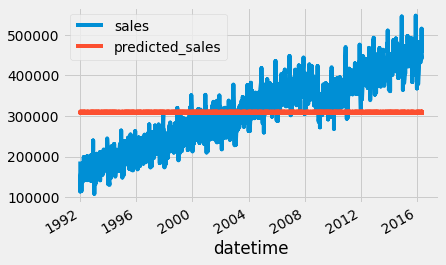

In [11]:
# Predictions are weak because our model doesn't have any features to grip on
# Note we can pass in lightgbm params as kwargs, such as learning_rate
fframe.predict(model="lightgbm", future_periods=10, learning_rate=.04)
fframe.get_predictions().plot.line()

In [17]:
# Let's add some features to help our model out
#fframe.calc_datetime_features()
fframe.lag_features(features=[fframe.target], lags=[1, 2, 3, 12]) # lagged features for 1 month ago, 2 months ago ..., 12 months ago
fframe.calc_statistical_features(features=[fframe.target], windows=[3, 6, 12], aggregations=['mean', 'std']) # 3, 6, and 12 month rolling aggregations for both mean and std
fframe.calc_ewma(fframe.target, windows=[3, 6, 12]) # 3, 6, 12 month exponential weighted moving averages

fframe.get_sample()

Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.


,state,store_id,category,sku,sales,sales_lag1,sales_lag2,sales_lag3,sales_lag12,sales_mean_roll3_lag1,sales_std_roll3_lag1,sales_mean_roll6_lag1,sales_std_roll6_lag1,sales_mean_roll12_lag1,sales_std_roll12_lag1,sales_ewma_roll3_lag1,sales_ewma_roll6_lag1,sales_ewma_roll12_lag1
datetime,,,,,,,,,,,,,,,,,,
1992-01-01,1,1,0,0,166650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1992-02-01,1,1,0,0,143127,166650.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1992-03-01,1,1,0,0,141547,143127.0,166650.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1992-04-01,1,1,0,0,146551,141547.0,143127.0,166650.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,145584.571429,NaN,NaN
1992-05-01,1,1,0,0,185642,146551.0,141547.0,143127.0,NaN,136511.0,NaN,136511.0,NaN,136511.0,NaN,146100.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2001-09-01,1,1,0,1,259143,327898.0,258772.0,292490.0,248797.0,466011.0,NaN,466011.0,NaN,466011.0,NaN,301922.122737,294211.941508,288129.804021
2001-10-01,1,1,0,1,285655,259143.0,327898.0,258772.0,268995.0,454325.0,NaN,454325.0,NaN,454325.0,NaN,280532.561369,284192.243934,283670.295696
2001-11-01,1,1,0,1,289515,285655.0,259143.0,327898.0,316367.0,456219.0,NaN,456219.0,NaN,456219.0,NaN,283093.780684,284610.174239,283975.634820


Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.


<AxesSubplot:xlabel='datetime'>

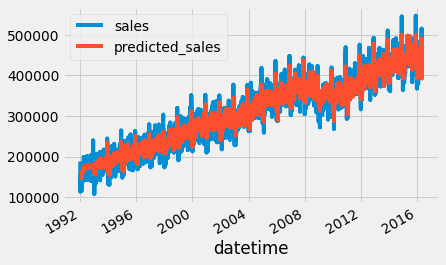

In [13]:
fframe.predict(model="lightgbm", future_periods=10, learning_rate=.04)
fframe.get_predictions().plot.line()

In [14]:
fframe.get_errors()

,Actuals,Predictions,Absolute Percent Error,Absolute Error,Squared Error
count,879.000000,879.000000,879.000000,879.000000,8.790000e+02
mean,411641.594994,317873.642088,0.221460,94361.060211,1.113795e+10
std,42561.390470,26122.019761,0.099034,47291.492839,8.932456e+09
min,293111.000000,263943.159166,0.000692,243.137931,5.911605e+04
25%,381982.500000,298576.903814,0.144590,55678.998610,3.100151e+09
50%,411086.000000,318358.509360,0.239347,96803.964734,9.371008e+09
75%,441577.500000,333253.830509,0.303256,132105.053856,1.745175e+10
max,546999.000000,392276.951439,0.420249,216432.096186,4.684285e+10


In [8]:
fframe.cross_validate(folds=3, model="lightgbm")

Running fold 1 of 3 with train shape (879, 5) and test shape (879, 5)
Running fold 2 of 3 with train shape (1758, 5) and test shape (879, 5)
Running fold 3 of 3 with train shape (2637, 5) and test shape (879, 5)


In [ ]:
fframe.save_fframe(name='lightgbm.pkl')

Saving to /home/nthor/forecastframe/forecastframe.pkl


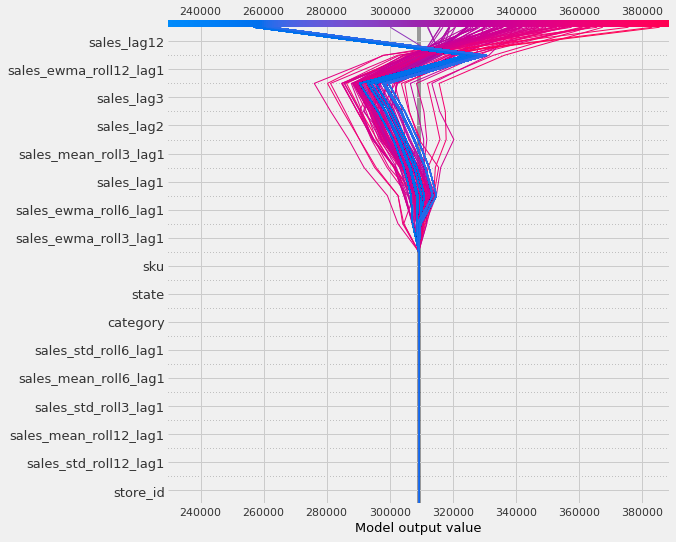

In [101]:
fframe.plot_shap_decision()